In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Device configuration
# I am using a Mac M3 chip, so I can't use CUDA, but if you are on nvidia, change this to CUDA
device = torch.device("mps")
torch.set_default_device(device)

In [3]:
# with a large batch size, the optimizer needs a faster learning rate to converge properly. 
num_epochs = 100
batch_size = 512
learning_rate = 0.02

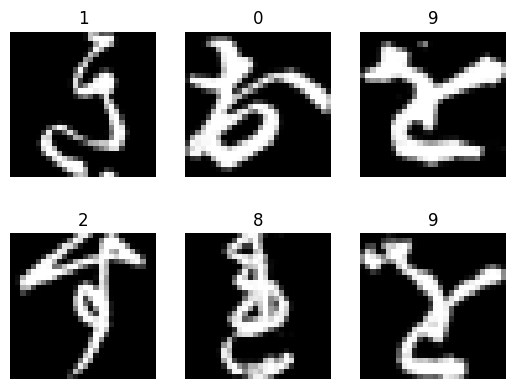

In [4]:
# KMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

# visualize some of the data
examples = iter(train_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(example_targets[i].item())
    plt.axis('off')
    plt.imshow(example_data[i][0], cmap='gray')

In [5]:
# make a cnn model with 2 convolutional layers and 2 fully connected layers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [6]:
# early_stopping.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=learning_rate, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=10, verbose=True)

 # to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
    

# Training loop
for epoch in range(num_epochs):
    
    # Train the model
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #capture loss
        train_losses.append(loss.item())

    # Validate the model
    model.eval()
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            output = model(test_images)
            loss = criterion(output, test_labels)
            valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # print training/validation statistics
    epoch_len = len(str(num_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    scheduler.step()


[  0/100] train_loss: 0.66911 valid_loss: 0.51848
Validation loss decreased (inf --> 0.518480).  Saving model ...
[  1/100] train_loss: 0.11534 valid_loss: 0.25366
Validation loss decreased (0.518480 --> 0.253663).  Saving model ...
[  2/100] train_loss: 0.06793 valid_loss: 0.25747
EarlyStopping counter: 1 out of 10
[  3/100] train_loss: 0.04234 valid_loss: 0.21625
Validation loss decreased (0.253663 --> 0.216253).  Saving model ...
[  4/100] train_loss: 0.02828 valid_loss: 0.24023
EarlyStopping counter: 1 out of 10
[  5/100] train_loss: 0.02452 valid_loss: 0.22316
EarlyStopping counter: 2 out of 10
[  6/100] train_loss: 0.01558 valid_loss: 0.26834
EarlyStopping counter: 3 out of 10
[  7/100] train_loss: 0.01431 valid_loss: 0.23957
EarlyStopping counter: 4 out of 10
[  8/100] train_loss: 0.01565 valid_loss: 0.23463
EarlyStopping counter: 5 out of 10
[  9/100] train_loss: 0.01054 valid_loss: 0.26024
EarlyStopping counter: 6 out of 10
[ 10/100] train_loss: 0.00565 valid_loss: 0.24867
Ear

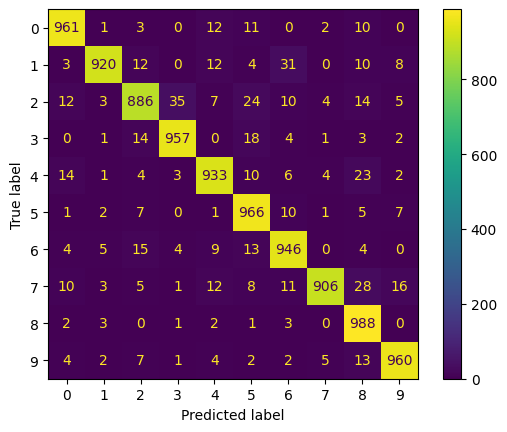

Model Architecture:
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

Model Evaluation:
Accuracy: 0.9423

Hyperparameters:
Learning Rate: 0.02
Batch Size: 512
Number of Epochs: 100


In [8]:
# Evaluation and confusion matrix
model.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
cm_display.plot()
plt.show()

# Model summary of accuracy and hyperparameters
print("Model Architecture:")
print(model)
print("\nModel Evaluation:")
print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))}")
print("\nHyperparameters:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")

